In [1]:
%pylab inline
plt.style.use("default")
import os, sys
import scipy
import random
import pandas as pd
import helpers as h
import spontHelpers as sh
import matplotlib.pyplot as plt
import utils as u
import ctils as cx
import matplotlib as mpl
from tqdm import tqdm 
from glob import glob
from scipy.io import loadmat
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

plt.rcParams['figure.figsize'] = (10, 10) 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def clean_unpack(data0):
    """returns clean and zscored signal"""
    resp0, spon0, istim0 = h.unbox(data0)

    resp0 = h.denoise_resp(resp0, spon0)

    resp0 = h.dupSignal(resp0, istim0)

    return resp0, spon0


def read_raw_activity(data0):
    resp, spon, _ = h.unbox(data0)
    return resp, spon


def get_subpops(x, y, dx, dy, resp):
    inxs = []
    subpops = []
    xmax = x.max()
    ymax = y.max()
    Xrange = np.arange(xmax, step=dx)
    Yrange = np.arange(ymax, step=dy)
    for x0 in Xrange:
        for y0 in Yrange:
            x1 = x0+dx
            y1 = y0+dx
            inx = np.where(((x>x0) & (x<x1)) & ((y > y0) & (y < y1)))
            inxs.append(inx)
            subpop = resp[:, :, inx].squeeze(axis=2)
            subpops.append((((x0, x1), (y0, y1)), subpop))
    return subpops, inxs 


def compute_cvPCA(resp0, nshuff, maxcols=np.inf):
    ss0 = u.shuff_cvPCA(resp0, nshuff=nshuff, maxcols=maxcols)
    ss0 = ss0.mean(axis=0)
    ss0 = ss0 / ss0.sum()

    return ss0

def compute_cvPCA100(resp0, nshuff, maxcols=100):
    """Return results for 100 components"""
    ss0 = cx.shuff_cvPCA(resp0, nshuff=nshuff, maxcols=maxcols)
    ss0 = ss0.mean(axis=0)
    ss0 = ss0 / ss0.sum()

    return ss0


def vanilaPCA(resp0):
    ss0, sv = u.vanila_PCA(resp0)
    ss0 = ss0/ss0.sum()
    sv = sv/sv.sum()

    return ss0, sv


In [3]:
data_root = "/camp/home/duuta/working/duuta/ppp0/data/stringer/live_data/"
data_files = [fname.split("/")[-1] for fname in glob(f"{data_root}natimg2800_M*.mat")]


In [4]:
spontList  = []# spont was recorded for 30mins ( mostly grey scale, interspersed with blanks)
respList = []
vanilaResp = []
vanilaSpon = []
for i in tqdm(range(6)):
    data = loadmat( os.path.join(data_root, data_files[i]), simplify_cells=True)
    resp0, spon0 = clean_unpack(data)
    resp, spon  = read_raw_activity(data)
    spontList.append(spon0)
    respList.append(resp0)
    vanilaSpon.append(spon)
    vanilaResp.append(resp)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:06<00:32,  6.45s/it]

 33%|███▎      | 2/6 [00:16<00:34,  8.63s/it]

 50%|█████     | 3/6 [00:22<00:22,  7.51s/it]

 67%|██████▋   | 4/6 [00:31<00:16,  8.12s/it]

 83%|████████▎ | 5/6 [00:37<00:07,  7.28s/it]

100%|██████████| 6/6 [00:43<00:00,  6.83s/it]

100%|██████████| 6/6 [00:43<00:00,  7.26s/it]

In [5]:
maxstim0 = spontList[1]
maxstim1 = spontList[3]

In [6]:
maxstim_res0 = respList[1]
maxstim_res1 = respList[3]

In [8]:
# this computation for alpha values for response
ra0 = []
ra1 = []
nstims = np.linspace(120, 2300, 100).astype('int')
for ns in tqdm(nstims):
    r0 = maxstim_res0[:ns, :]
    r1 = maxstim_res1[:ns, :]
    sr0 = compute_cvPCA100(r0, 10, maxcols=100)
    sr1 = compute_cvPCA100(r1, 10, maxcols=100)
    ras0, _, _ = cx.get_powerlaw(sr0, np.arange(5, 90).astype('int'))
    ras1, _, _ = cx.get_powerlaw(sr1, np.arange(5, 90).astype('int'))
    ra0.append(ras0)
    ra1.append(ras1)


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:32<53:34, 32.47s/it]

  2%|▏         | 2/100 [01:04<52:29, 32.14s/it]

  3%|▎         | 3/100 [01:35<51:26, 31.82s/it]

  4%|▍         | 4/100 [02:07<50:41, 31.68s/it]

  5%|▌         | 5/100 [02:38<49:55, 31.53s/it]

  6%|▌         | 6/100 [03:10<49:36, 31.67s/it]

  7%|▋         | 7/100 [03:42<49:01, 31.63s/it]

  8%|▊         | 8/100 [04:13<48:34, 31.68s/it]

  9%|▉         | 9/100 [04:45<48:02, 31.68s/it]

 10%|█         | 10/100 [05:17<47:38, 31.76s/it]

 11%|█         | 11/100 [05:48<46:57, 31.65s/it]

 12%|█▏        | 12/100 [06:20<46:24, 31.64s/it]

 13%|█▎        | 13/100 [06:51<45:42, 31.52s/it]

 14%|█▍        | 14/100 [07:23<45:06, 31.47s/it]

 15%|█▌        | 15/100 [07:54<44:36, 31.49s/it]

 16%|█▌        | 16/100 [08:26<44:03, 31.47s/it]

 17%|█▋        | 17/100 [08:57<43:20, 31.33s/it]

 18%|█▊        | 18/100 [09:28<42:46, 31.30s/it]

 19%|█▉        | 19/100 [09:59<42:12, 31.26s/it]

 20%|██        | 20/100 [10:30<41:41, 31.26s/it]

 21%|██        | 21/100 [11:02<41:13, 31.31s/it]

 22%|██▏       | 22/100 [11:33<40:46, 31.37s/it]

 23%|██▎       | 23/100 [12:04<40:09, 31.29s/it]

 24%|██▍       | 24/100 [12:36<39:38, 31.29s/it]

 25%|██▌       | 25/100 [13:07<39:06, 31.29s/it]

 26%|██▌       | 26/100 [13:38<38:41, 31.37s/it]

 27%|██▋       | 27/100 [14:10<38:13, 31.42s/it]

 28%|██▊       | 28/100 [14:41<37:40, 31.39s/it]

 29%|██▉       | 29/100 [15:13<37:21, 31.58s/it]

 30%|███       | 30/100 [15:45<36:52, 31.61s/it]

 31%|███       | 31/100 [16:17<36:23, 31.65s/it]

 32%|███▏      | 32/100 [16:48<35:42, 31.50s/it]

 33%|███▎      | 33/100 [17:19<35:02, 31.38s/it]

 34%|███▍      | 34/100 [17:50<34:29, 31.36s/it]

 35%|███▌      | 35/100 [18:22<33:58, 31.36s/it]

 36%|███▌      | 36/100 [18:53<33:25, 31.33s/it]

 37%|███▋      | 37/100 [19:25<33:00, 31.44s/it]

 38%|███▊      | 38/100 [19:56<32:25, 31.39s/it]

 39%|███▉      | 39/100 [20:28<32:00, 31.48s/it]

 40%|████      | 40/100 [20:59<31:31, 31.52s/it]

 41%|████      | 41/100 [21:30<30:55, 31.44s/it]

 42%|████▏     | 42/100 [22:02<30:27, 31.51s/it]

 43%|████▎     | 43/100 [22:33<29:50, 31.42s/it]

 44%|████▍     | 44/100 [23:05<29:22, 31.47s/it]

 45%|████▌     | 45/100 [23:36<28:46, 31.39s/it]

 46%|████▌     | 46/100 [24:07<28:14, 31.37s/it]

 47%|████▋     | 47/100 [24:39<27:45, 31.43s/it]

 48%|████▊     | 48/100 [25:11<27:19, 31.53s/it]

 49%|████▉     | 49/100 [25:42<26:45, 31.48s/it]

 50%|█████     | 50/100 [26:14<26:14, 31.49s/it]

 51%|█████     | 51/100 [26:45<25:41, 31.45s/it]

 52%|█████▏    | 52/100 [27:17<25:21, 31.70s/it]

 53%|█████▎    | 53/100 [27:49<24:45, 31.60s/it]

 54%|█████▍    | 54/100 [28:20<24:09, 31.52s/it]

 55%|█████▌    | 55/100 [28:51<23:37, 31.49s/it]

 56%|█████▌    | 56/100 [29:23<23:03, 31.44s/it]

 57%|█████▋    | 57/100 [29:54<22:32, 31.45s/it]

 58%|█████▊    | 58/100 [30:25<21:58, 31.40s/it]

 59%|█████▉    | 59/100 [30:57<21:26, 31.39s/it]

 60%|██████    | 60/100 [31:28<20:58, 31.45s/it]

 61%|██████    | 61/100 [32:00<20:28, 31.50s/it]

 62%|██████▏   | 62/100 [32:32<19:57, 31.52s/it]

 63%|██████▎   | 63/100 [33:03<19:30, 31.64s/it]

 64%|██████▍   | 64/100 [33:35<18:59, 31.66s/it]

 65%|██████▌   | 65/100 [34:07<18:24, 31.55s/it]

 66%|██████▌   | 66/100 [34:38<17:52, 31.54s/it]

 67%|██████▋   | 67/100 [35:10<17:22, 31.60s/it]

 68%|██████▊   | 68/100 [35:42<16:55, 31.73s/it]

 69%|██████▉   | 69/100 [36:14<16:24, 31.77s/it]

 70%|███████   | 70/100 [36:45<15:53, 31.78s/it]

 71%|███████   | 71/100 [37:17<15:21, 31.79s/it]

 72%|███████▏  | 72/100 [37:49<14:51, 31.83s/it]

 73%|███████▎  | 73/100 [38:21<14:17, 31.76s/it]

 74%|███████▍  | 74/100 [38:53<13:47, 31.82s/it]

 75%|███████▌  | 75/100 [39:24<13:14, 31.78s/it]

 76%|███████▌  | 76/100 [39:56<12:43, 31.82s/it]

 77%|███████▋  | 77/100 [40:28<12:12, 31.86s/it]

 78%|███████▊  | 78/100 [41:00<11:40, 31.84s/it]

 79%|███████▉  | 79/100 [41:32<11:10, 31.92s/it]

 80%|████████  | 80/100 [42:04<10:39, 31.98s/it]

 81%|████████  | 81/100 [42:36<10:06, 31.93s/it]

 82%|████████▏ | 82/100 [43:08<09:33, 31.85s/it]

 83%|████████▎ | 83/100 [43:39<09:00, 31.79s/it]

 84%|████████▍ | 84/100 [44:11<08:28, 31.77s/it]

 85%|████████▌ | 85/100 [44:42<07:53, 31.55s/it]

 86%|████████▌ | 86/100 [45:13<07:20, 31.45s/it]

 87%|████████▋ | 87/100 [45:45<06:50, 31.58s/it]

 88%|████████▊ | 88/100 [46:17<06:20, 31.72s/it]

 89%|████████▉ | 89/100 [46:50<05:50, 31.88s/it]

 90%|█████████ | 90/100 [47:22<05:20, 32.03s/it]

 91%|█████████ | 91/100 [47:54<04:47, 31.90s/it]

 92%|█████████▏| 92/100 [48:25<04:15, 31.88s/it]

 93%|█████████▎| 93/100 [48:58<03:43, 31.97s/it]

 94%|█████████▍| 94/100 [49:30<03:12, 32.16s/it]

 95%|█████████▌| 95/100 [50:03<02:41, 32.24s/it]

 96%|█████████▌| 96/100 [50:35<02:08, 32.15s/it]

 97%|█████████▋| 97/100 [51:06<01:36, 32.07s/it]

 98%|█████████▊| 98/100 [51:38<01:03, 31.83s/it]

 99%|█████████▉| 99/100 [52:09<00:31, 31.80s/it]

100%|██████████| 100/100 [52:42<00:00, 31.92s/it]

100%|██████████| 100/100 [52:42<00:00, 31.62s/it]

In [7]:
ra0 =[0.9591142084814154, 0.9596352000439352, 0.9554177206988254, 0.9540409903482658, 0.957038955035978, 0.955968936760646, 0.9577120786663721, 0.9542783008370425, 0.9603293311280942, 0.9548712725716003, 0.9542385315961918, 0.9547683772510882, 0.9532833587821253, 0.9562813275943525, 0.9583965271114846, 0.959121778027039, 0.9534041652466342, 0.953663257188475, 0.9546697550122413, 0.956280909650264, 0.9577834294613896, 0.9582985288231901, 0.954500578501512, 0.9566669449790364, 0.9526387273558363, 0.9546315162061457, 0.9559107220455169, 0.9548062347876594, 0.9583319190159655, 0.955219943335854, 0.9582138977546291, 0.9567105091607184, 0.954064853636386, 0.9505195082083254, 0.9528630290948288, 0.9560092600013038, 0.9615478050136598, 0.9617803025793555, 0.95694042561963, 0.9597765258334703, 0.9564598795476363, 0.9566334913221234, 0.9532594922516097, 0.9536597342833083, 0.958732952684775, 0.9542670288497462, 0.9540076233740694, 0.9547688360051562, 0.9551807027607414, 0.9562728719097864, 0.9588720339427319, 0.9560734747753575, 0.952311384568449, 0.9529489798158421, 0.9518326269337132, 0.9542488650846765, 0.9584912253660579, 0.9536940804178341, 0.9585651919689203, 0.9515490433818772, 0.9542814166064075, 0.9532001882808264, 0.9591399464778352, 0.960445118565546, 0.9571574329791225, 0.9542445199772525, 0.9559817400756193, 0.9524941864496929, 0.954634164151247, 0.9526684383316487, 0.9552242153681845, 0.9574980883899814, 0.9552669842161814, 0.9582634003947698, 0.955155500097033, 0.9553392198575822, 0.9535632715578178, 0.955959110535512, 0.9552027922805764, 0.955488449344173, 0.9583218878456207, 0.954965296969858, 0.9578116186184406, 0.954235908821385, 0.9563905059843052, 0.9539768946156831, 0.9553429840645096, 0.9594438714735817, 0.9514713391484116, 0.953037109001039, 0.9560006456847486, 0.9546936240779144, 0.9589460302651491, 0.9555072830071251, 0.9551384687231947, 0.9546401094687862, 0.9577905959879746, 0.954129748265536, 0.9592604887587534, 0.9612836070669086]

In [8]:
ra1 =[1.0204585539387077, 1.014486583288447, 1.0172274810084043, 1.0178887969164947, 1.0123576332681041, 1.0158519581057217, 1.0154750343639902, 1.019081537601237, 1.01389821102655, 1.0177810774824052, 1.0152370807137312, 1.0146878149603555, 1.0170106504898384, 1.012315827992602, 1.0158407907632665, 1.0139509608447455, 1.0238664083053235, 1.0148081794066308, 1.017137365845317, 1.0187428418135835, 1.0094768261138989, 1.0171929563417386, 1.0164456178792765, 1.014262212369004, 1.017032709470778, 1.011476624987793, 1.0175470691392143, 1.0202699031964884, 1.016596154342697, 1.0199996721695124, 1.0175454286858843, 1.0178877572639902, 1.0162896066938036, 1.0176711119761377, 1.0196730296601124, 1.0105556185775513, 1.0136177493606566, 1.0132932480631371, 1.0106150399051632, 1.0167917820028685, 1.0173761526649119, 1.015775413187343, 1.0236335256174374, 1.0182723426865694, 1.0164585841208436, 1.0145680675605286, 1.0140848610535342, 1.0168353202350708, 1.0177782958247432, 1.0194828632099937, 1.0138868905593308, 1.0143393542968508, 1.01594176009469, 1.0154625981946581, 1.017192809597951, 1.0194110420373366, 1.0116626841393235, 1.0150151675811792, 1.0176756954583657, 1.0124981023601738, 1.0160112792667215, 1.0175401761983414, 1.013810242806356, 1.0211235891613206, 1.0199661523121586, 1.0139656943608992, 1.0198556602771303, 1.020952444829056, 1.0195775835264993, 1.0129647005560065, 1.0131305899505814, 1.0096910154773036, 1.0130311418535054, 1.019252615725881, 1.0095214693450878, 1.0123524024750488, 1.018872854434637, 1.0164560532314653, 1.0167618396088671, 1.0146193178758949, 1.0144630406903454, 1.0204589157942363, 1.0158231933030266, 1.0141485103476637, 1.0225355598724368, 1.0143172002603646, 1.0105736430118906, 1.015205447070446, 1.0181782392179228, 1.0138197751585116, 1.0161582083982603, 1.0154273573021058, 1.0187871977952667, 1.0155231889103173, 1.0153151352919048, 1.015836560539002, 1.015447220325919, 1.0179331187587466, 1.0150939013831681, 1.0159231027056377]

In [9]:
ppa0 = [0.6125202734986988, 0.5952657940242835, 0.5755028518483343, 0.5367562695968019, 0.5397158515743097, 0.5175341049809703, 0.5103154301214523, 0.532409889034731, 0.5169892189808487, 0.5306908927946014, 0.5467642662633186, 0.5951222902910129, 0.6417431183169916, 0.6565390945138853, 0.6851872264958173, 0.6942666229501842, 0.7159807123427021, 0.7298615796575565, 0.7190056463886155, 0.6860773607583565, 0.6334796374556495, 0.6263852116486477, 0.6133432229519105, 0.6182181003585147, 0.6129558251707425, 0.6416036129661852, 0.6600598130678255, 0.6578496098525182, 0.6859530049023806, 0.6900405644338464, 0.6938032956113342, 0.7178151805459055, 0.7252428677884492, 0.7429241272136169, 0.7278435362945734, 0.7076222589956799, 0.7240023775346032, 0.7343581449757961, 0.7584128213598129, 0.7562166779203444, 0.7473780268207717, 0.6067332680943619, 0.6540518869269317, 0.6708043993512983, 0.7154363034908188, 0.7346371549677417, 0.7438512782834912, 0.7454350927756863, 0.6953990300174768, 0.7056425175233864, 0.7006325798471913, 0.7400331072024142, 0.7604965234606147, 0.7881533089890529, 0.7977869213090275, 0.8052243035336193, 0.8235123769920618, 0.8197725851223617, 0.810661388476912, 0.8130716337118609, 0.8130868314165784, 0.8154982121450595, 0.8316233351788163, 0.844603443400883, 0.846562787332111, 0.8405595706832922, 0.8300027414456103, 0.834810062551327, 0.8283497882624762, 0.8357510213416383, 0.8406538034001985, 0.8344385183293564, 0.8019041441610978, 0.8274930231482561, 0.8384044292380686, 0.8422423671097563, 0.8425607176437823, 0.8491961025784437, 0.8400475903266944, 0.8320573374153049, 0.82577606049389, 0.8260948007578873, 0.8287035938301068, 0.8311808071995164, 0.8416627099716859, 0.8340378343643883, 0.8387568900145279, 0.7869350389907085, 0.7826778805829734, 0.7610023543236593, 0.7795758924088434, 0.7810811014982747, 0.8351589570760167, 0.8960570807104005, 0.8366404512006781, 0.823395252113978, 0.8234044001853219, 0.8340465107880181, 0.8409487726143872, 0.8586290775193772]

In [10]:
ppa1 = [0.6567971085410211, 0.6255459412833881, 0.6333220335076567, 0.6233383970576478, 0.6387828804214958, 0.6544238710654017, 0.6475376545976511, 0.618079686564263, 0.593002083932263, 0.583708137314363, 0.5731268681506396, 0.5714685021480864, 0.5756764808588625, 0.5603464747734812, 0.5452974413085472, 0.5409903157099104, 0.5382718090761155, 0.5431346522710099, 0.5394775774009422, 0.5431021734938675, 0.5514383847936932, 0.5526623646707323, 0.5581598299442874, 0.5563195013814223, 0.5620909095203283, 0.5646349099021774, 0.5629464352818383, 0.5740087955615167, 0.5724405588370184, 0.5812178224730378, 0.629643409028024, 0.6432101659361673, 0.6342815881292398, 0.5864283064487429, 0.5574793398217743, 0.5638540137106132, 0.5563291215454895, 0.5533465693740561, 0.5464619398459116, 0.5512840858114366, 0.5481839210174132, 0.5553774579205099, 0.5556417828419298, 0.5504208075505818, 0.5520568246891444, 0.5569177125369819, 0.5523070769832037, 0.5480801442139001, 0.5509191124410093, 0.5491241981371396, 0.5490393360347875, 0.5577628780174186, 0.5663895061812189, 0.5742161820025827, 0.5828235921817079, 0.5807261054301225, 0.5782077466061398, 0.5849971649562528, 0.5877055260780687, 0.5840559437936074, 0.586020681101327, 0.5852529968040646, 0.5861277963709848, 0.5887284853326432, 0.5881324360881949, 0.5900090613402731, 0.5957575346237218, 0.5990443974205696, 0.5965744273804069, 0.5973371703673537, 0.5999643244349315, 0.6006396407674919, 0.6012028203139577, 0.6069829055862591, 0.607194035741905, 0.6125902213256724, 0.6142920345051436, 0.6129465138475871, 0.6116591972675186, 0.6082528663984027, 0.6190582541184604, 0.6122693431843245, 0.6157229731632703, 0.6100893460744198, 0.6063238453991902, 0.6076768998826877, 0.599530070947799, 0.6012724014786536, 0.6033544022175219, 0.6014168392883862, 0.6008460257045483, 0.6005791970333398, 0.5922700831798676, 0.6032718874193875, 0.6006292417135316, 0.6104301783332112, 0.6133228579288718, 0.61370169086044, 0.6077407402163347, 0.6077634728021679]

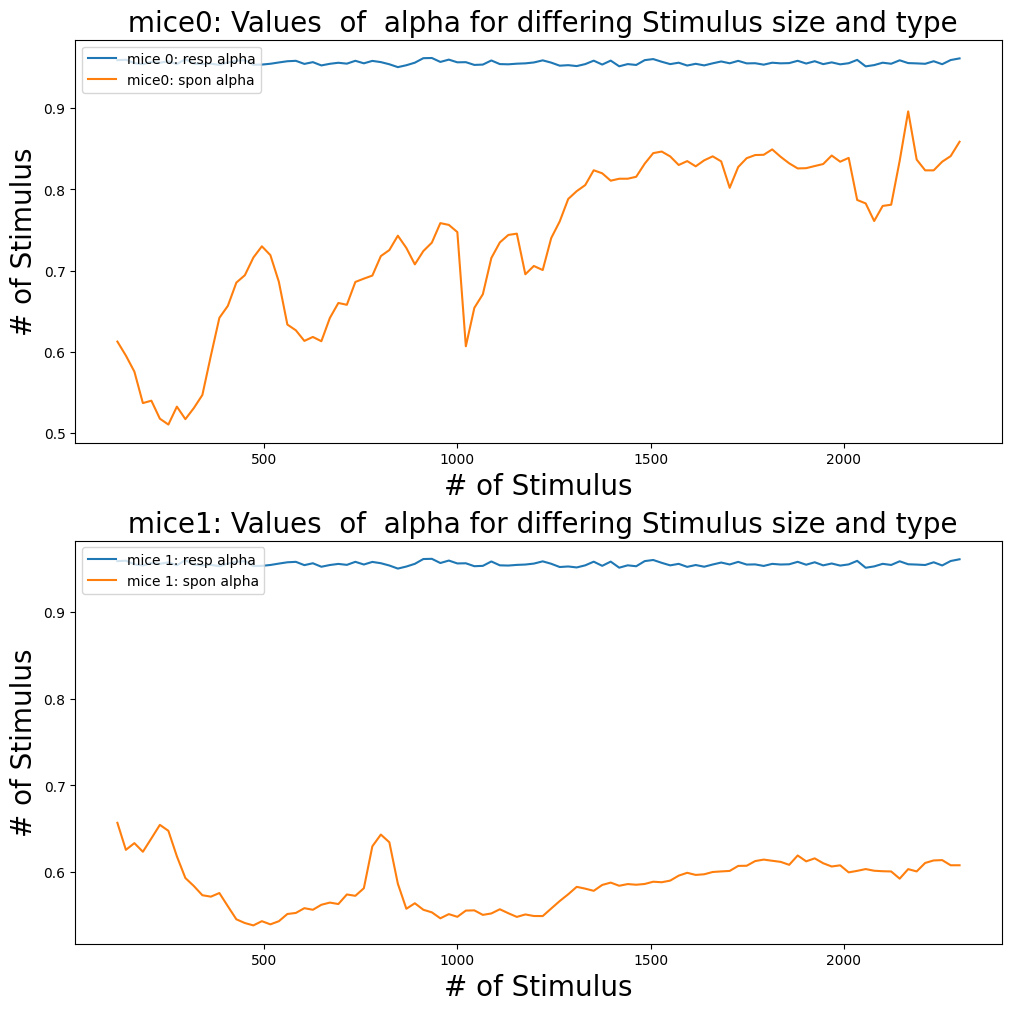

In [14]:
nstims = np.linspace(120, 2300, 100).astype('int')
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), layout='constrained')

axs[0].plot(nstims, ra0, label="mice 0: resp alpha")
axs[0].plot(nstims, ppa0, label="mice0: spon alpha")
axs[0].set_xlabel("# of Stimulus", fontsize=20)
axs[0].set_ylabel("# of Stimulus", fontsize=20)
axs[0].set_title(" mice0: Values  of  alpha for differing Stimulus size and type", fontsize=20)
axs[0].legend(loc='upper left')


axs[1].plot(nstims, ra0, label="mice 1: resp alpha")
axs[1].plot(nstims, ppa1, label="mice 1: spon alpha")
axs[1].set_xlabel("# of Stimulus", fontsize=20)
axs[1].set_ylabel("# of Stimulus", fontsize=20)
axs[1].set_title(" mice1: Values  of  alpha for differing Stimulus size and type", fontsize=20)
axs[1].legend(loc='upper left')


In [11]:
ppa0 = []
ppa1 = []
nstims = np.linspace(120, 2500, 100).astype('int')
for ns in tqdm(nstims):
    p0 = sh.ssplit(maxstim0[:ns, :])
    p1 = sh.ssplit(maxstim1[:ns, :])
    t0 = compute_cvPCA100(p0, 10, maxcols=100)
    t1 = compute_cvPCA100(p1, 10, maxcols=100)
    ap0, _, _ = u.get_powerlaw(t0, np.arange(5, 90).astype('int'))
    ap1, _, _ = u.get_powerlaw(t1, np.arange(5, 90).astype('int'))
    ppa0.append(ap0)
    ppa1.append(ap1)


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:16,  1.38s/it]

  2%|▏         | 2/100 [00:04<04:12,  2.58s/it]

  3%|▎         | 3/100 [00:08<04:56,  3.06s/it]

  4%|▍         | 4/100 [00:12<05:27,  3.42s/it]

  5%|▌         | 5/100 [00:16<05:56,  3.75s/it]

  6%|▌         | 6/100 [00:21<06:18,  4.02s/it]

  7%|▋         | 7/100 [00:26<06:36,  4.26s/it]

  8%|▊         | 8/100 [00:31<07:00,  4.57s/it]

  9%|▉         | 9/100 [00:36<07:19,  4.83s/it]

 10%|█         | 10/100 [00:42<07:34,  5.05s/it]

 11%|█         | 11/100 [00:48<07:50,  5.28s/it]

 12%|█▏        | 12/100 [00:54<08:05,  5.52s/it]

 13%|█▎        | 13/100 [01:00<08:20,  5.76s/it]

 14%|█▍        | 14/100 [01:06<08:34,  5.99s/it]

 15%|█▌        | 15/100 [01:13<08:41,  6.13s/it]

 16%|█▌        | 16/100 [01:20<08:50,  6.32s/it]

 17%|█▋        | 17/100 [01:27<09:01,  6.52s/it]

 18%|█▊        | 18/100 [01:34<09:14,  6.76s/it]

 19%|█▉        | 19/100 [01:41<09:25,  6.98s/it]

 20%|██        | 20/100 [01:49<09:37,  7.21s/it]

 21%|██        | 21/100 [01:57<09:49,  7.47s/it]

 22%|██▏       | 22/100 [02:05<09:57,  7.66s/it]

 23%|██▎       | 23/100 [02:14<10:04,  7.85s/it]

 24%|██▍       | 24/100 [02:22<10:17,  8.12s/it]

 25%|██▌       | 25/100 [02:31<10:26,  8.36s/it]

 26%|██▌       | 26/100 [02:41<10:38,  8.63s/it]

 27%|██▋       | 27/100 [02:50<10:49,  8.90s/it]

 28%|██▊       | 28/100 [03:00<10:59,  9.17s/it]

 29%|██▉       | 29/100 [03:10<11:06,  9.39s/it]

 30%|███       | 30/100 [03:20<11:13,  9.63s/it]

 31%|███       | 31/100 [03:30<11:19,  9.85s/it]

 32%|███▏      | 32/100 [03:41<11:21, 10.03s/it]

 33%|███▎      | 33/100 [03:52<11:29, 10.28s/it]

 34%|███▍      | 34/100 [04:03<11:33, 10.51s/it]

 35%|███▌      | 35/100 [04:14<11:38, 10.74s/it]

 36%|███▌      | 36/100 [04:26<11:43, 10.99s/it]

 37%|███▋      | 37/100 [04:37<11:45, 11.20s/it]

 38%|███▊      | 38/100 [04:53<12:49, 12.41s/it]

 39%|███▉      | 39/100 [05:08<13:40, 13.45s/it]

 40%|████      | 40/100 [05:25<14:14, 14.24s/it]

 41%|████      | 41/100 [05:41<14:42, 14.95s/it]

 42%|████▏     | 42/100 [05:58<14:57, 15.48s/it]

 43%|████▎     | 43/100 [06:15<15:10, 15.97s/it]

 44%|████▍     | 44/100 [06:32<15:18, 16.41s/it]

 45%|████▌     | 45/100 [06:50<15:23, 16.79s/it]

 46%|████▌     | 46/100 [07:08<15:20, 17.04s/it]

 47%|████▋     | 47/100 [07:26<15:16, 17.29s/it]

 48%|████▊     | 48/100 [07:44<15:15, 17.60s/it]

 49%|████▉     | 49/100 [08:02<15:12, 17.89s/it]

 50%|█████     | 50/100 [08:21<15:07, 18.15s/it]

 51%|█████     | 51/100 [08:40<15:00, 18.39s/it]

 52%|█████▏    | 52/100 [08:59<14:52, 18.60s/it]

 53%|█████▎    | 53/100 [09:18<14:43, 18.79s/it]

 54%|█████▍    | 54/100 [09:38<14:37, 19.07s/it]

 55%|█████▌    | 55/100 [09:58<14:31, 19.36s/it]

 56%|█████▌    | 56/100 [10:19<14:25, 19.67s/it]

 57%|█████▋    | 57/100 [10:39<14:17, 19.94s/it]

 58%|█████▊    | 58/100 [11:00<14:08, 20.19s/it]

 59%|█████▉    | 59/100 [11:21<13:59, 20.48s/it]

 60%|██████    | 60/100 [11:43<13:51, 20.79s/it]

 61%|██████    | 61/100 [12:04<13:42, 21.09s/it]

 62%|██████▏   | 62/100 [12:27<13:33, 21.42s/it]

 63%|██████▎   | 63/100 [12:49<13:19, 21.62s/it]

 64%|██████▍   | 64/100 [13:11<13:08, 21.90s/it]

 65%|██████▌   | 65/100 [13:34<12:56, 22.19s/it]

 66%|██████▌   | 66/100 [13:57<12:44, 22.48s/it]

 67%|██████▋   | 67/100 [14:21<12:31, 22.78s/it]

 68%|██████▊   | 68/100 [14:45<12:18, 23.09s/it]

 69%|██████▉   | 69/100 [15:09<12:04, 23.37s/it]

 70%|███████   | 70/100 [15:33<11:48, 23.61s/it]

 71%|███████   | 71/100 [15:57<11:34, 23.94s/it]

 72%|███████▏  | 72/100 [16:22<11:17, 24.21s/it]

 73%|███████▎  | 73/100 [16:47<11:00, 24.45s/it]

 74%|███████▍  | 74/100 [17:13<10:41, 24.67s/it]

 75%|███████▌  | 75/100 [17:38<10:22, 24.89s/it]

 76%|███████▌  | 76/100 [18:04<10:07, 25.29s/it]

 77%|███████▋  | 77/100 [18:30<09:48, 25.58s/it]

 78%|███████▊  | 78/100 [18:57<09:26, 25.74s/it]

 79%|███████▉  | 79/100 [19:23<09:06, 26.04s/it]

 80%|████████  | 80/100 [19:50<08:44, 26.21s/it]

 81%|████████  | 81/100 [20:16<08:20, 26.34s/it]

 82%|████████▏ | 82/100 [20:44<07:57, 26.55s/it]

 83%|████████▎ | 83/100 [21:11<07:35, 26.79s/it]

 84%|████████▍ | 84/100 [21:39<07:12, 27.06s/it]

 85%|████████▌ | 85/100 [22:06<06:49, 27.28s/it]

 86%|████████▌ | 86/100 [22:34<06:25, 27.53s/it]

 87%|████████▋ | 87/100 [23:03<06:02, 27.87s/it]

 88%|████████▊ | 88/100 [23:31<05:36, 28.01s/it]

 89%|████████▉ | 89/100 [24:00<05:11, 28.30s/it]

 90%|█████████ | 90/100 [24:30<04:45, 28.56s/it]

 91%|█████████ | 91/100 [24:59<04:19, 28.88s/it]

 92%|█████████▏| 92/100 [25:29<03:53, 29.16s/it]

 93%|█████████▎| 93/100 [25:59<03:26, 29.48s/it]

 94%|█████████▍| 94/100 [26:30<02:58, 29.76s/it]

 95%|█████████▌| 95/100 [27:00<02:29, 29.94s/it]

 96%|█████████▌| 96/100 [27:31<02:01, 30.26s/it]

 97%|█████████▋| 97/100 [28:02<01:31, 30.55s/it]

 98%|█████████▊| 98/100 [28:34<01:01, 30.85s/it]

 99%|█████████▉| 99/100 [29:06<00:31, 31.17s/it]

100%|██████████| 100/100 [29:38<00:00, 31.40s/it]

100%|██████████| 100/100 [29:38<00:00, 17.78s/it]

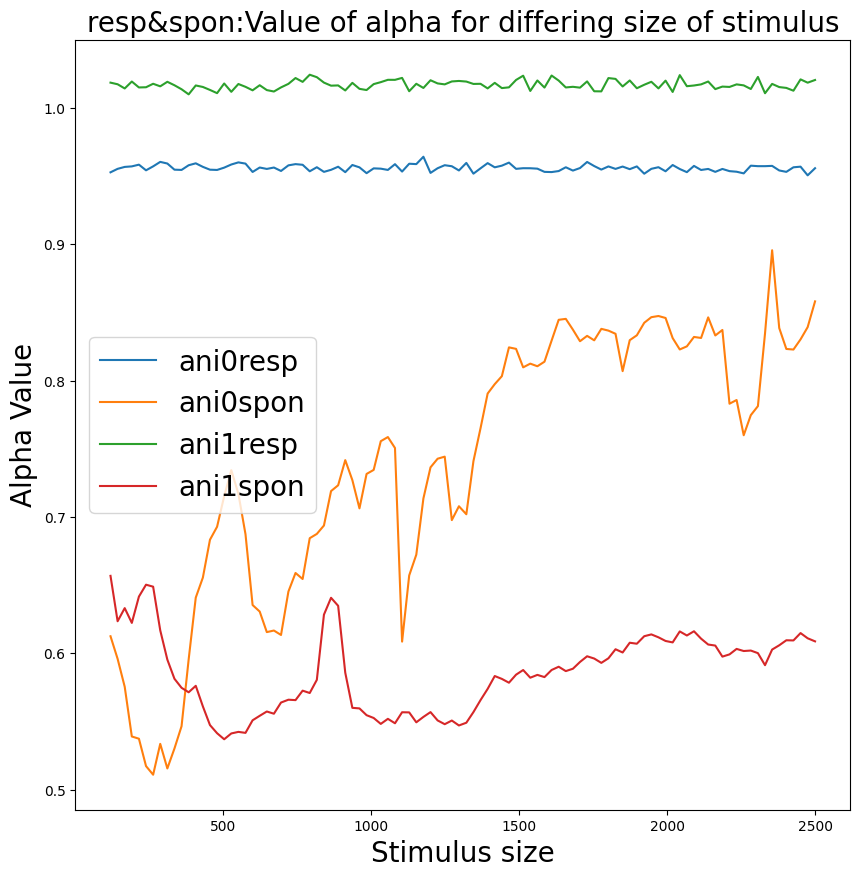

In [18]:
plt.plot(nstims, ra0, label='ani0resp')
plt.plot(nstims, ppa0, label='ani0spon')
plt.plot(nstims, ra1, label='ani1resp')
plt.plot(nstims, ppa1, label='ani1spon')
plt.xlabel("Stimulus size", fontsize=20)
plt.ylabel("Alpha Value", fontsize=20)
plt.title("resp&spon:Value of alpha for differing size of stimulus", fontsize=20)
plt.legend(fontsize=20)
# I need to change the region of computation, and increase the variability explained.


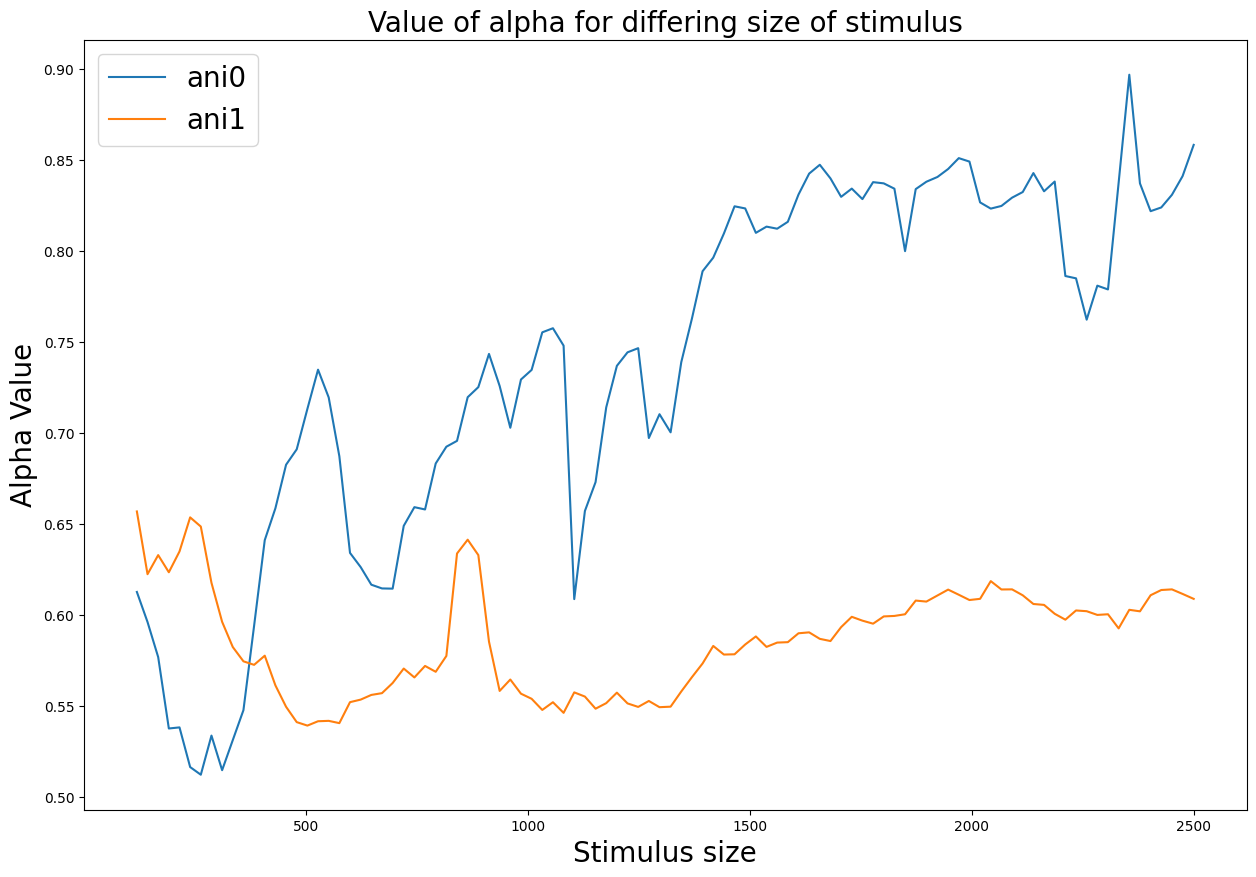

In [12]:
plt.plot(nstims, ppa0, label='ani0')
plt.plot(nstims, ppa1, label='ani1')
plt.xlabel("Stimulus size", fontsize=20)
plt.ylabel("Alpha Value", fontsize=20)
plt.title("Value of alpha for differing size of stimulus", fontsize=20)
plt.legend(fontsize=20)
# I need to change the region of computation, and increase the variability explained.

In [15]:
# change the end points of stimulus 
sppa0 = []
sppa1 = []
nstims = np.linspace(120, 2500, 100).astype('int')
for ns in nstims:
    ps0 = sh.ssplit(maxstim0[:ns, :])
    ps1 = sh.ssplit(maxstim1[:ns, :])
    ts0 = compute_cvPCA(ps0, 10, maxcols=100)
    ts1 = compute_cvPCA(ps1, 10, maxcols=100)
    aps0, _, _ = u.get_powerlaw(ts0, np.arange(5, 90).astype('int'))
    aps1, _, _ = u.get_powerlaw(ts1, np.arange(5, 90).astype('int'))
    sppa0.append(aps0)
    sppa1.append(aps1)

ValueError: could not broadcast input array from shape (120,) into shape (100,)

In [ ]:
plt.plot(nstims, sppa0, label='ani0')
plt.plot(nstims, sppa1, label='ani1')
plt.xlabel("Stimulus size", fontsize=20)
plt.ylabel("Alpha Value", fontsize=20)
plt.title("Value of alpha for differing size of stimulus", fontsize=20)
plt.legend(fontsize=20, loc='upper left')

<Figure size 2000x2000 with 0 Axes>

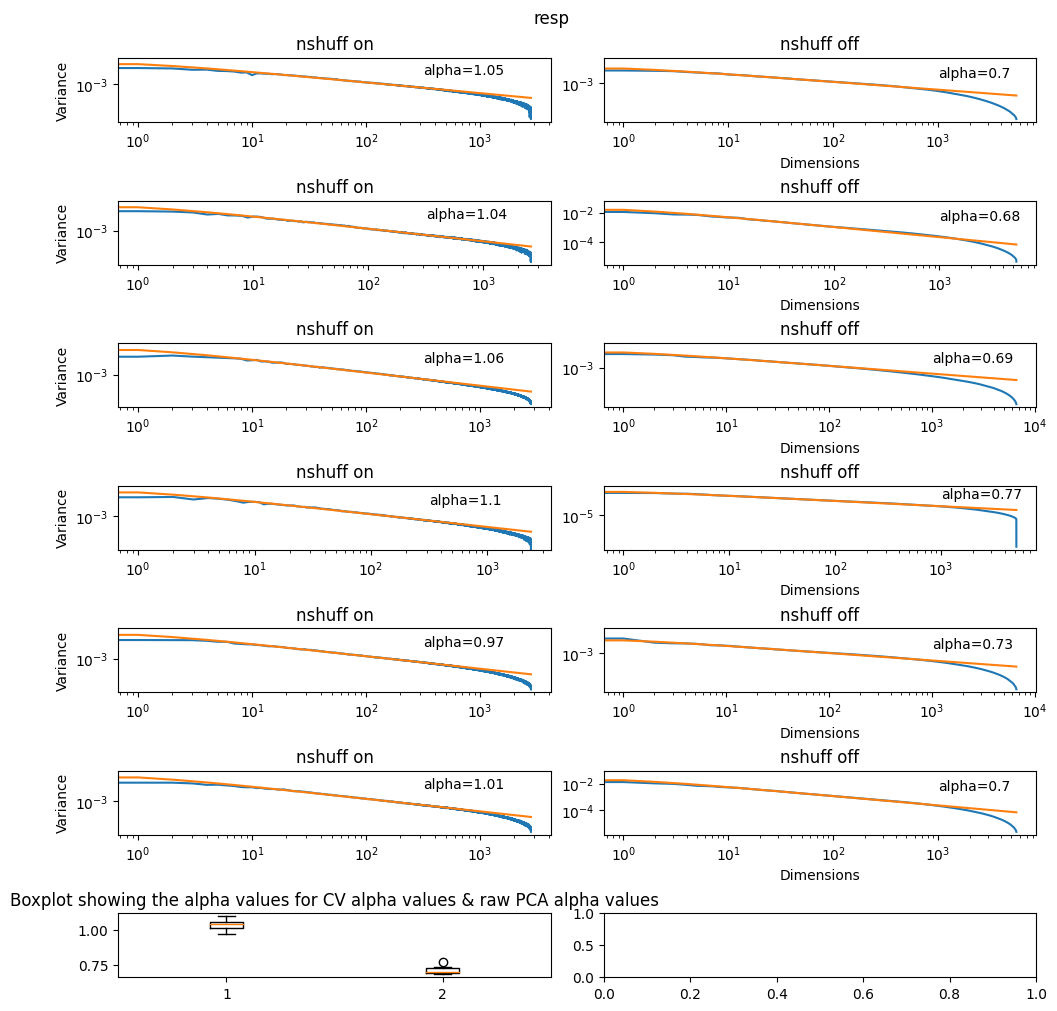

In [30]:
# use all the components to make clear the changes.
# add arrs for alpha values.
vanilaalpha = []
cvalpha = []
plt.figure(figsize=(20, 20))
fig0, axs = plt.subplots(nrows=7, ncols=2, layout='constrained', figsize=(10, 10))
for i, (arr, arr0) in enumerate(zip(respList, vanilaResp)):
    rr0_sn = compute_cvPCA(arr, 10, maxcols=np.inf)
    rr0_so, _ = vanilaPCA(arr0)
    a0_sn, yp0, _ = u.get_powerlaw(rr0_sn, np.arange(11, 500).astype('int'))
    a0_so, yp1, _ = u.get_powerlaw(rr0_so, np.arange(11, 90).astype('int'))
    a0_sn, a0_so = round(a0_sn, 2), round(a0_so, 2)
    cvalpha.append(a0_sn)
    vanilaalpha.append(a0_so)
    
    axs[i, 0].loglog(np.arange(0, rr0_sn.size), rr0_sn/rr0_sn.sum())
    axs[i, 0].loglog(np.arange(0, rr0_sn.size), yp0)
    axs[i, 0].text(x=10**2.5, y=10**-2, s=f"alpha={a0_sn}")
    axs[i, 0].set_title("nshuff on")
    axs[i, 0].set_ylabel("Variance")
    
    axs[i, 1].loglog(np.arange(0, rr0_so.size), rr0_so/rr0_so.sum(), label='Shuff off')
    axs[i, 1].loglog(np.arange(0, rr0_so.size), yp1)
    axs[i, 1].text(x=10**3, y=10**-2.5, s=f"alpha={a0_so}")
    axs[i, 1].set_title("nshuff off")
    axs[i, 1].set_xlabel("Dimensions")

axs[6, 0].boxplot([cvalpha, vanilaalpha])
axs[6, 0].set_title("Boxplot showing the alpha values for CV alpha values & raw PCA alpha values")
fig0.suptitle('resp')
plt.savefig("behaviourof_nshuff.png")

In [22]:
nwsList = []
nstim = 280
for arr in spontList:
    sp0 = arr[:nstim, :]
    nwsList.append(sp0)

In [23]:
nrois = 9000
nrois_stims = []
for arr in spontList:
    sp00 = arr[:nstim, :nrois]
    nrois_stims.append(sp00)

In [10]:
for arr in nwsList:
    print(arr.shape)

(280, 10079)
(280, 14062)
(280, 10145)
(280, 11449)
(280, 9476)
(280, 10103)


In [24]:
for arr in nrois_stims:
    print(arr.shape)

(280, 9000)
(280, 9000)
(280, 9000)
(280, 9000)
(280, 9000)
(280, 9000)


In [26]:
aa0= []
for arr in tqdm(nrois_stims):
    sa0 = sh.ssplit(arr)
    sa1 = compute_cvPCA100(sa0, 100, maxcols=100)
    av, _, _ = u.get_powerlaw(sa1, np.arange(11, 90).astype('int'))
    aa0.append(av)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:17<01:25, 17.05s/it]

 33%|███▎      | 2/6 [00:33<01:06, 16.68s/it]

 50%|█████     | 3/6 [00:49<00:49, 16.56s/it]

 67%|██████▋   | 4/6 [01:06<00:32, 16.49s/it]

 83%|████████▎ | 5/6 [01:22<00:16, 16.45s/it]

100%|██████████| 6/6 [01:39<00:00, 16.43s/it]

100%|██████████| 6/6 [01:39<00:00, 16.51s/it]

Text(0, 0.5, 'Val of alpha')

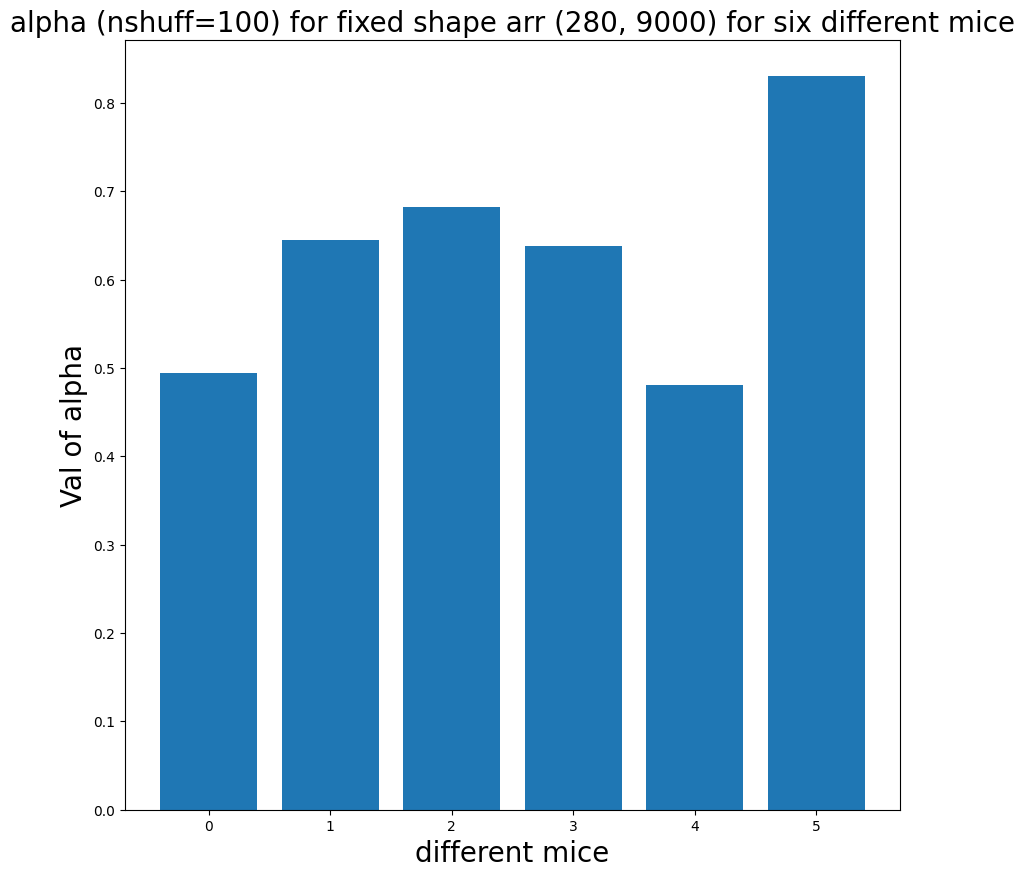

In [27]:

plt.bar(list(np.arange(6)), aa0)
plt.title('alpha (nshuff=100) for fixed shape arr (280, 9000) for six different mice', fontsize=20)
plt.xlabel("different mice", fontsize=20)
plt.ylabel("Val of alpha", fontsize=20)

In [28]:
a0 = []
for arr in nrois_stims:
    s0 = sh.ssplit(arr)
    ss1 = compute_cvPCA100(s0, 10,  maxcols=100)
    a, _, _ = u.get_powerlaw(ss1, np.arange(11, 90).astype('int'))
    a0.append(a)

Text(0, 0.5, 'Val of alpha')

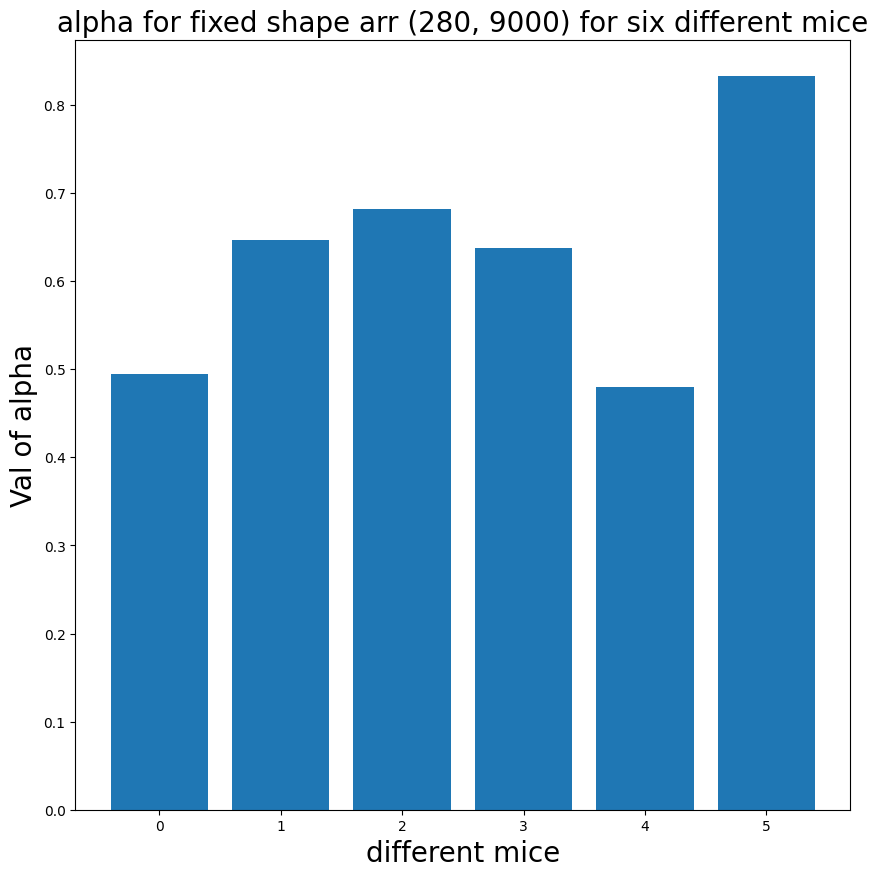

In [29]:
plt.bar(list(np.arange(6)), a0)
plt.title('alpha for fixed shape arr (280, 9000) for six different mice', fontsize=20)
plt.xlabel("different mice", fontsize=20)
plt.ylabel("Val of alpha", fontsize=20)

In [17]:
ass = []
kiks = []
for arr in nwsList:
    ss = sh.ssplit(arr)
    kiks.append(arr.shape[1])

    ss0 = compute_cvPCA(ss, 10,  maxcols=100)
    a, _, _ = u.get_powerlaw(ss0, np.arange(11, 90).astype('int'))
    ass.append(a)

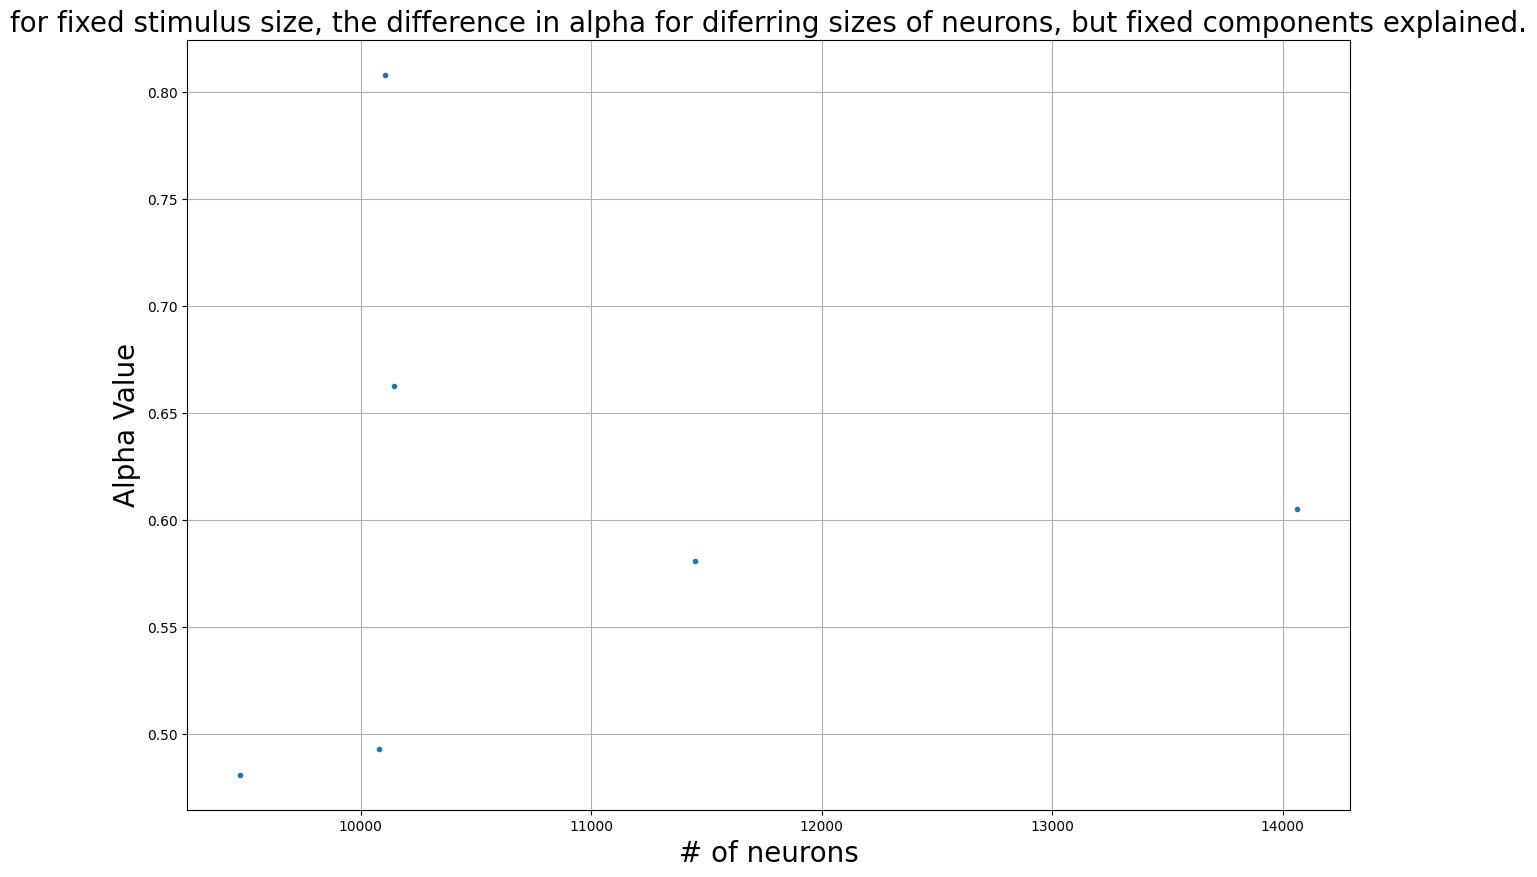

In [18]:
plt.bar(kiks, ass, '.')
plt.title("for fixed stimulus size, the difference in alpha for diferring sizes of neurons, but fixed components explained.", fontsize=20)
plt.xlabel("# of neurons", fontsize=20)
plt.ylabel("Alpha Value", fontsize=20)
plt.grid(True)

# kept stimulus size fixed but #neruons & ncomponents fixed.
# 

In [38]:
tas = []
pps = []
for arr in nrois_stims:
    t0 = sh.ssplit(arr)
    t1, tv = vanilaPCA(s0)
    tt, _, _ = u.get_powerlaw(t1, np.arange(11, 90).astype('int'))
    tp, _, _ = u.get_powerlaw(tv, np.arange(11, 90).astype('int'))
    tas.append(tt)
    pps.append(tp)



Text(0, 0.5, 'Value of alpha')

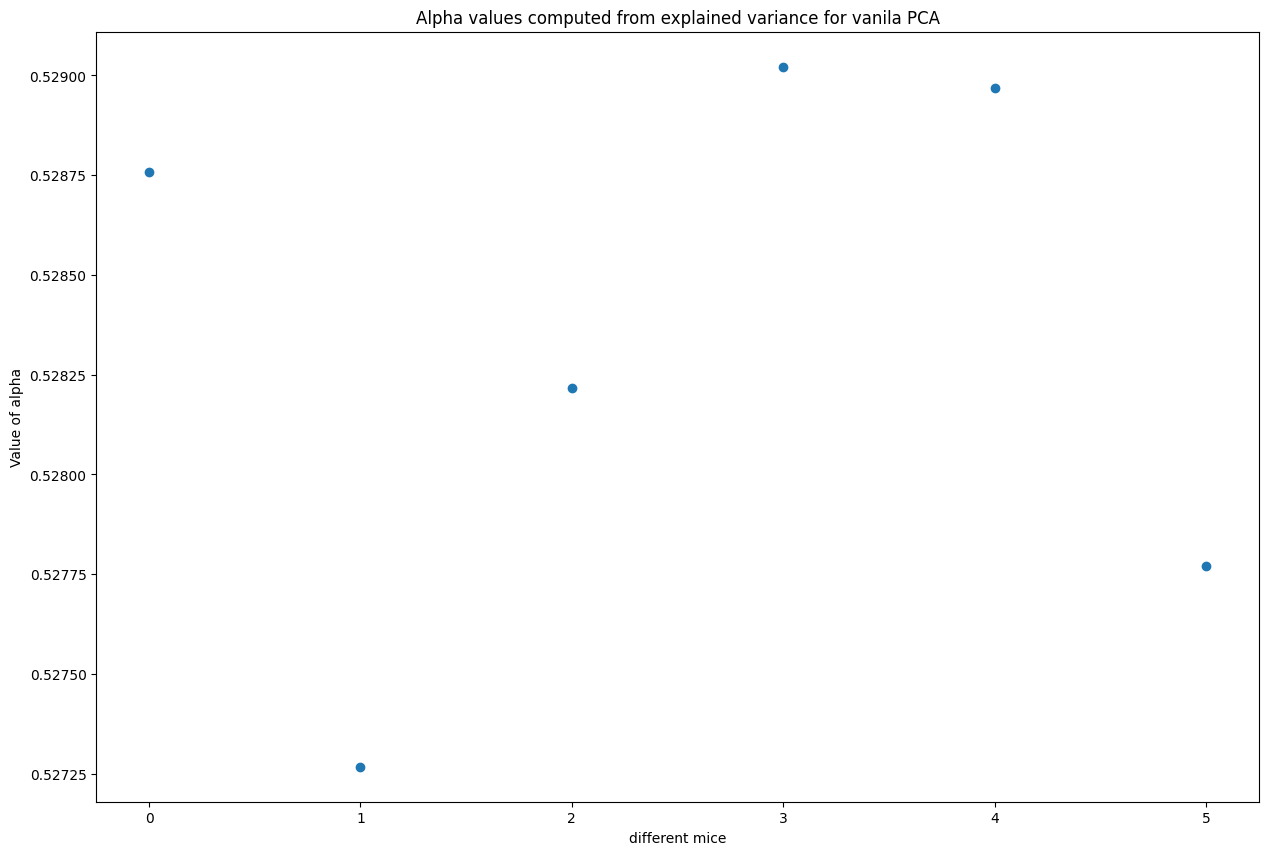

In [42]:
# difference in alpha values across different sizes of neurons.
plt.bar(list(np.arange(6)), tas)
plt.title('Alpha values computed from explained variance for vanila PCA')
plt.xlabel('different mice')
plt.ylabel('Value of alpha')

Text(0, 0.5, 'Value of alpha')

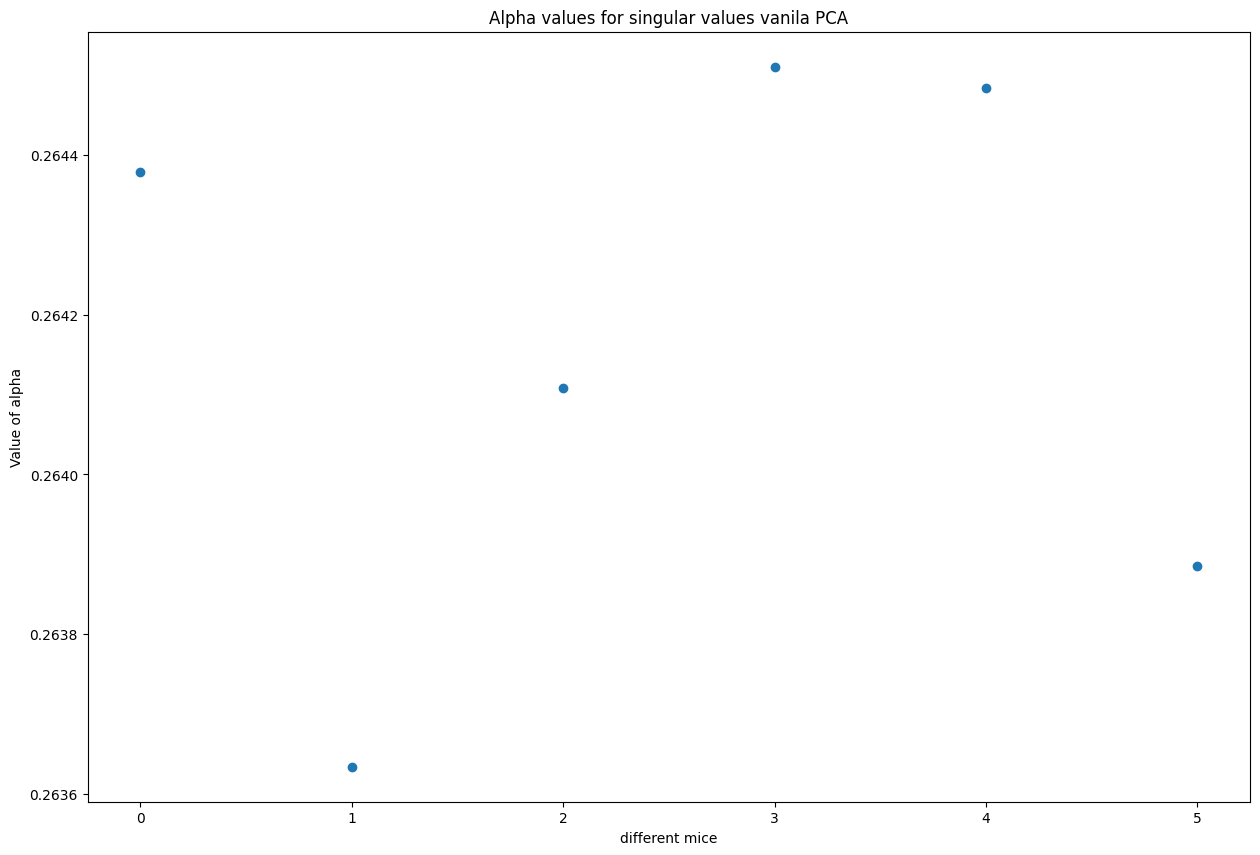

In [41]:
plt.scatter(list(np.arange(6)), pps)
plt.title('Alpha values for singular values vanila PCA')
plt.xlabel('different mice')
plt.ylabel('Value of alpha')